## relation extraction experiment
> Tutorial author：余海阳（yuhaiyang@zju.edu.cn)

On this demo，we use `pcnn` model to extract relations.
We hope this demo can help you understand the process of conctruction knowledge graph and the the principles and common methods of triplet extraction.

This demo uses `Python3`.

### Dataset
In this example,we get some Chinese text to extract the triples.

sentence|relation|head|tail
:---:|:---:|:---:|:---:
孔正锡在2005年以一部温馨的爱情电影《长腿叔叔》敲开电影界大门。|导演|长腿叔叔|孔正锡
《伤心的树》是吴宗宪的音乐作品，收录在《你比从前快乐》专辑中。|所属专辑|伤心的树|你比从前快乐
2000年8月，「天坛大佛」荣获「香港十大杰出工程项目」第四名。|所在城市|天坛大佛|香港


- train.csv: It contains 6 training triples,each lines represent one triple,sorted by sentence, relationship, head entity and tail entity, and separated by `,`.
- valid.csv: It contains 3 validing triples,each lines represent one triple,sorted by sentence, relationship, head entity and tail entity, and separated by `,`.
- test.csv:  It contains 3 testing triples,each lines represent one triple,sorted by sentence, relationship, head entity and tail entity, and separated by `,`.
- relation.csv: It contains 4 relation triples,each lines represent one triple,sorted by sentence, relationship, head entity and tail entity, and separated by `,`.

### PCNN 

![PCNN](https://github.com/zjunlp/DeepKE/blob/main/tutorial-notebooks/re/standard/img/PCNN.jpg?raw=1)

The sentence information mainly includes word embedding and position embedding.After the convolution layer,according to the position of head tail, it is divided into three sections for maximum pooling,and then through the full connection layer, the relationship information of the sentence can be obtained.


In [ ]:
# Run the neural network with pytorch and confirm whether it is installed before running
!pip install torch
!pip install matplotlib
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.5 MB/s 
     |████████████████████████████████| 59 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 55.4 MB/s 
     |████████████████████████████████| 3.3 MB 63.9 MB/s 
     |████████████████████████████████| 895 kB 44.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# import the whole modules
import os
import csv
import math
import pickle
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import precision_recall_fscore_support
from typing import List, Tuple, Dict, Any, Sequence, Optional, Union
from transformers import BertTokenizer, BertModel

logger = logging.getLogger(__name__)

In [ ]:
# Configuration file of model parameters
# use_pcnn Parameter controls whether there is a piece_ Wise pooling

class Config(object):
    model_name = 'cnn'  # ['cnn', 'gcn', 'lm']
    use_pcnn = True
    min_freq = 1
    pos_limit = 20
    out_path = 'data/out'   
    batch_size = 2  
    word_dim = 10
    pos_dim = 5
    dim_strategy = 'sum'  # ['sum', 'cat']
    out_channels = 20
    intermediate = 10
    kernel_sizes = [3, 5, 7]
    activation = 'gelu'
    pooling_strategy = 'max'
    dropout = 0.3
    epoch = 10
    num_relations = 4
    learning_rate = 3e-4
    lr_factor = 0.7 # 学习率的衰减率
    lr_patience = 3 # 学习率衰减的等待epoch
    weight_decay = 1e-3 # L2正则
    early_stopping_patience = 6
    train_log = True
    log_interval = 1
    show_plot = True
    only_comparison_plot = False
    plot_utils = 'matplot'
    lm_file = 'bert-base-chinese'
    lm_num_hidden_layers = 2
    rnn_layers = 2
    
cfg = Config()

In [ ]:
# Word token builds a one hot dictionary, and then inputs it to the embedding layer to obtain the corresponding word information matrix
# 0 is pad by default and 1 is unknown
class Vocab(object):
    def __init__(self, name: str = 'basic', init_tokens = ["[PAD]", "[UNK]"]):
        self.name = name
        self.init_tokens = init_tokens
        self.trimed = False
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {}
        self.count = 0
        self._add_init_tokens()

    def _add_init_tokens(self):
        for token in self.init_tokens:
            self._add_word(token)

    def _add_word(self, word: str):
        if word not in self.word2idx:
            self.word2idx[word] = self.count
            self.word2count[word] = 1
            self.idx2word[self.count] = word
            self.count += 1
        else:
            self.word2count[word] += 1

    def add_words(self, words: Sequence):
        for word in words:
            self._add_word(word)

    def trim(self, min_freq=2, verbose: Optional[bool] = True):
        assert min_freq == int(min_freq), f'min_freq must be integer, can\'t be {min_freq}'
        min_freq = int(min_freq)
        if min_freq < 2:
            return
        if self.trimed:
            return
        self.trimed = True

        keep_words = []
        new_words = []

        for k, v in self.word2count.items():
            if v >= min_freq:
                keep_words.append(k)
                new_words.extend([k] * v)
        if verbose:
            before_len = len(keep_words)
            after_len = len(self.word2idx) - len(self.init_tokens)
            logger.info('vocab after be trimmed, keep words [{} / {}] = {:.2f}%'.format(before_len, after_len, before_len / after_len * 100))

        # Reinitialize dictionaries
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {}
        self.count = 0
        self._add_init_tokens()
        self.add_words(new_words)

In [ ]:
# Functions required for preprocessing
Path = str

def load_csv(fp: Path, is_tsv: bool = False, verbose: bool = True) -> List:
    if verbose:
        logger.info(f'load csv from {fp}')

    dialect = 'excel-tab' if is_tsv else 'excel'
    with open(fp, encoding='utf-8') as f:
        reader = csv.DictReader(f, dialect=dialect)
        return list(reader)

    
def load_pkl(fp: Path, verbose: bool = True) -> Any:
    if verbose:
        logger.info(f'load data from {fp}')

    with open(fp, 'rb') as f:
        data = pickle.load(f)
        return data


def save_pkl(data: Any, fp: Path, verbose: bool = True) -> None:
    if verbose:
        logger.info(f'save data in {fp}')

    with open(fp, 'wb') as f:
        pickle.dump(data, f)
    
    
def _handle_relation_data(relation_data: List[Dict]) -> Dict:
    rels = dict()
    for d in relation_data:
        rels[d['relation']] = {
            'index': int(d['index']),
            'head_type': d['head_type'],
            'tail_type': d['tail_type'],
        }
    return rels


def _add_relation_data(rels: Dict,data: List) -> None:
    for d in data:
        d['rel2idx'] = rels[d['relation']]['index']
        d['head_type'] = rels[d['relation']]['head_type']
        d['tail_type'] = rels[d['relation']]['tail_type']


def _convert_tokens_into_index(data: List[Dict], vocab):
    unk_str = '[UNK]'
    unk_idx = vocab.word2idx[unk_str]

    for d in data:
        d['token2idx'] = [vocab.word2idx.get(i, unk_idx) for i in d['tokens']]


def _add_pos_seq(train_data: List[Dict], cfg):
    for d in train_data:
        d['head_offset'], d['tail_offset'], d['lens'] = int(d['head_offset']), int(d['tail_offset']), int(d['lens'])
        entities_idx = [d['head_offset'], d['tail_offset']] if d['head_offset'] < d['tail_offset'] else [d['tail_offset'], d['head_offset']]

        d['head_pos'] = list(map(lambda i: i - d['head_offset'], list(range(d['lens']))))
        d['head_pos'] = _handle_pos_limit(d['head_pos'], int(cfg.pos_limit))

        d['tail_pos'] = list(map(lambda i: i - d['tail_offset'], list(range(d['lens']))))
        d['tail_pos'] = _handle_pos_limit(d['tail_pos'], int(cfg.pos_limit))

        if cfg.use_pcnn:
            d['entities_pos'] = [1] * (entities_idx[0] + 1) + [2] * (entities_idx[1] - entities_idx[0] - 1) +\
                                [3] * (d['lens'] - entities_idx[1])

            
def _handle_pos_limit(pos: List[int], limit: int) -> List[int]:
    for i, p in enumerate(pos):
        if p > limit:
            pos[i] = limit
        if p < -limit:
            pos[i] = -limit
    return [p + limit + 1 for p in pos]


def seq_len_to_mask(seq_len: Union[List, np.ndarray, torch.Tensor], max_len=None, mask_pos_to_true=True):
    if isinstance(seq_len, list):
        seq_len = np.array(seq_len)

    if isinstance(seq_len, np.ndarray):
        seq_len = torch.from_numpy(seq_len)

    if isinstance(seq_len, torch.Tensor):
        assert seq_len.dim() == 1, logger.error(f"seq_len can only have one dimension, got {seq_len.dim()} != 1.")
        batch_size = seq_len.size(0)
        max_len = int(max_len) if max_len else seq_len.max().long()
        broad_cast_seq_len = torch.arange(max_len).expand(batch_size, -1).to(seq_len.device)
        if mask_pos_to_true:
            mask = broad_cast_seq_len.ge(seq_len.unsqueeze(1))
        else:
            mask = broad_cast_seq_len.lt(seq_len.unsqueeze(1))
    else:
        raise logger.error("Only support 1-d list or 1-d numpy.ndarray or 1-d torch.Tensor.")

    return mask

In [ ]:
# Preprocess
logger.info('load raw files...')
train_fp = os.path.join('data/train.csv')
valid_fp = os.path.join('data/valid.csv')
test_fp = os.path.join('data/test.csv')
relation_fp = os.path.join('data/relation.csv')

train_data = load_csv(train_fp)
valid_data = load_csv(valid_fp)
test_data = load_csv(test_fp)
relation_data = load_csv(relation_fp)

for d in train_data:
    d['tokens'] = eval(d['tokens'])
for d in valid_data:
    d['tokens'] = eval(d['tokens'])
for d in test_data:
    d['tokens'] = eval(d['tokens'])
    
logger.info('convert relation into index...')
rels = _handle_relation_data(relation_data)
_add_relation_data(rels, train_data)
_add_relation_data(rels, valid_data)
_add_relation_data(rels, test_data)

logger.info('verify whether use pretrained language models...')
logger.info('build vocabulary...')
vocab = Vocab('word')
train_tokens = [d['tokens'] for d in train_data]
valid_tokens = [d['tokens'] for d in valid_data]
test_tokens = [d['tokens'] for d in test_data]
sent_tokens = [*train_tokens, *valid_tokens, *test_tokens]
for sent in sent_tokens:
    vocab.add_words(sent)
vocab.trim(min_freq=cfg.min_freq)

logger.info('convert tokens into index...')
_convert_tokens_into_index(train_data, vocab)
_convert_tokens_into_index(valid_data, vocab)
_convert_tokens_into_index(test_data, vocab)

logger.info('build position sequence...')
_add_pos_seq(train_data, cfg)
_add_pos_seq(valid_data, cfg)
_add_pos_seq(test_data, cfg)

logger.info('save data for backup...')
os.makedirs(cfg.out_path, exist_ok=True)
train_save_fp = os.path.join(cfg.out_path, 'train.pkl')
valid_save_fp = os.path.join(cfg.out_path, 'valid.pkl')
test_save_fp = os.path.join(cfg.out_path, 'test.pkl')
save_pkl(train_data, train_save_fp)
save_pkl(valid_data, valid_save_fp)
save_pkl(test_data, test_save_fp)

vocab_save_fp = os.path.join(cfg.out_path, 'vocab.pkl')
vocab_txt = os.path.join(cfg.out_path, 'vocab.txt')
save_pkl(vocab, vocab_save_fp)
logger.info('save vocab in txt file, for watching...')
with open(vocab_txt, 'w', encoding='utf-8') as f:
    f.write(os.linesep.join(vocab.word2idx.keys()))

In [ ]:
# pytorch construct Dataset
def collate_fn(cfg):
    def collate_fn_intra(batch):
        batch.sort(key=lambda data: int(data['lens']), reverse=True)
        max_len = int(batch[0]['lens'])
        
        def _padding(x, max_len):
            return x + [0] * (max_len - len(x))
        
        def _pad_adj(adj, max_len):
            adj = np.array(adj)
            pad_len = max_len - adj.shape[0]
            for i in range(pad_len):
                adj = np.insert(adj, adj.shape[-1], 0, axis=1)
            for i in range(pad_len):
                adj = np.insert(adj, adj.shape[0], 0, axis=0)
            return adj
        
        x, y = dict(), []
        word, word_len = [], []
        head_pos, tail_pos = [], []
        pcnn_mask = []
        adj_matrix = []
        for data in batch:
            word.append(_padding(data['token2idx'], max_len))
            word_len.append(int(data['lens']))
            y.append(int(data['rel2idx']))
            
            if cfg.model_name != 'lm':
                head_pos.append(_padding(data['head_pos'], max_len))
                tail_pos.append(_padding(data['tail_pos'], max_len))
                if cfg.model_name == 'gcn':
                    head = eval(data['dependency'])
                    adj = head_to_adj(head, directed=True, self_loop=True)
                    adj_matrix.append(_pad_adj(adj, max_len))

                if cfg.use_pcnn:
                    pcnn_mask.append(_padding(data['entities_pos'], max_len))

        x['word'] = torch.tensor(word)
        x['lens'] = torch.tensor(word_len)
        y = torch.tensor(y)
        
        if cfg.model_name != 'lm':
            x['head_pos'] = torch.tensor(head_pos)
            x['tail_pos'] = torch.tensor(tail_pos)
            if cfg.model_name == 'gcn':
                x['adj'] = torch.tensor(adj_matrix)
            if cfg.model_name == 'cnn' and cfg.use_pcnn:
                x['pcnn_mask'] = torch.tensor(pcnn_mask)

        return x, y
    
    return collate_fn_intra


class CustomDataset(Dataset):
    def __init__(self, fp):
        self.file = load_pkl(fp)

    def __getitem__(self, item):
        sample = self.file[item]
        return sample

    def __len__(self):
        return len(self.file)

In [ ]:
# embedding layer
class Embedding(nn.Module):
    def __init__(self, config):
        super(Embedding, self).__init__()

        # self.xxx = config.xxx
        self.vocab_size = config.vocab_size
        self.word_dim = config.word_dim
        self.pos_size = config.pos_limit * 2 + 2
        self.pos_dim = config.pos_dim if config.dim_strategy == 'cat' else config.word_dim
        self.dim_strategy = config.dim_strategy

        self.wordEmbed = nn.Embedding(self.vocab_size,self.word_dim,padding_idx=0)
        self.headPosEmbed = nn.Embedding(self.pos_size,self.pos_dim,padding_idx=0)
        self.tailPosEmbed = nn.Embedding(self.pos_size,self.pos_dim,padding_idx=0)


    def forward(self, *x):
        word, head, tail = x
        word_embedding = self.wordEmbed(word)
        head_embedding = self.headPosEmbed(head)
        tail_embedding = self.tailPosEmbed(tail)

        if self.dim_strategy == 'cat':
            return torch.cat((word_embedding,head_embedding, tail_embedding), -1)
        elif self.dim_strategy == 'sum':
            # 此时 pos_dim == word_dim
            return word_embedding + head_embedding + tail_embedding
        else:
            raise Exception('dim_strategy must choose from [sum, cat]')

In [ ]:
# Gelu activation function, specified by transformer, works better than relu
class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [ ]:
# cnn model
class CNN(nn.Module):
    def __init__(self, config):

        super(CNN, self).__init__()

        if config.dim_strategy == 'cat':
            self.in_channels = config.word_dim + 2 * config.pos_dim
        else:
            self.in_channels = config.word_dim

        self.out_channels = config.out_channels
        self.kernel_sizes = config.kernel_sizes
        self.activation = config.activation
        self.pooling_strategy = config.pooling_strategy
        self.dropout = config.dropout
        for kernel_size in self.kernel_sizes:
            assert kernel_size % 2 == 1, "kernel size has to be odd numbers."

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=self.in_channels,
                      out_channels=self.out_channels,
                      kernel_size=k,
                      stride=1,
                      padding=k // 2,
                      dilation=1,
                      groups=1,
                      bias=False) for k in self.kernel_sizes
        ])

        assert self.activation in ['relu', 'lrelu', 'prelu', 'selu', 'celu', 'gelu', 'sigmoid', 'tanh'], \
            'activation function must choose from [relu, lrelu, prelu, selu, celu, gelu, sigmoid, tanh]'
        self.activations = nn.ModuleDict([
            ['relu', nn.ReLU()],
            ['lrelu', nn.LeakyReLU()],
            ['prelu', nn.PReLU()],
            ['selu', nn.SELU()],
            ['celu', nn.CELU()],
            ['gelu', GELU()],
            ['sigmoid', nn.Sigmoid()],
            ['tanh', nn.Tanh()],
        ])

        # pooling
        assert self.pooling_strategy in ['max', 'avg', 'cls'], 'pooling strategy must choose from [max, avg, cls]'

        self.dropout = nn.Dropout(self.dropout)

    def forward(self, x, mask=None):
        
        x = torch.transpose(x, 1, 2)

        act_fn = self.activations[self.activation]

        x = [act_fn(conv(x)) for conv in self.convs]
        x = torch.cat(x, dim=1)

        if mask is not None:
            mask = mask.unsqueeze(1)
            x = x.masked_fill_(mask, 1e-12)

        if self.pooling_strategy == 'max':
            xp = F.max_pool1d(x, kernel_size=x.size(2)).squeeze(2)

        elif self.pooling_strategy == 'avg':
            x_len = mask.squeeze().eq(0).sum(-1).unsqueeze(-1).to(torch.float).to(device=mask.device)
            xp = torch.sum(x, dim=-1) / x_len

        else:
            xp = x[:, :, 0]

        x = x.transpose(1, 2)
        x = self.dropout(x)
        xp = self.dropout(xp)

        return x, xp  


In [ ]:
# pcnn model
class PCNN(nn.Module):
    def __init__(self, cfg):
        super(PCNN, self).__init__()

        self.use_pcnn = cfg.use_pcnn

        self.embedding = Embedding(cfg)
        self.cnn = CNN(cfg)
        self.fc1 = nn.Linear(len(cfg.kernel_sizes) * cfg.out_channels, cfg.intermediate)
        self.fc2 = nn.Linear(cfg.intermediate, cfg.num_relations)
        self.dropout = nn.Dropout(cfg.dropout)

        if self.use_pcnn:
            self.fc_pcnn = nn.Linear(3 * len(cfg.kernel_sizes) * cfg.out_channels,
                                     len(cfg.kernel_sizes) * cfg.out_channels)
            self.pcnn_mask_embedding = nn.Embedding(4, 3)
            masks = torch.tensor([[0, 0, 0], [100, 0, 0], [0, 100, 0], [0, 0, 100]])
            self.pcnn_mask_embedding.weight.data.copy_(masks)
            self.pcnn_mask_embedding.weight.requires_grad = False


    def forward(self, x):
        word, lens, head_pos, tail_pos = x['word'], x['lens'], x['head_pos'], x['tail_pos']
        mask = seq_len_to_mask(lens)

        inputs = self.embedding(word, head_pos, tail_pos)
        out, out_pool = self.cnn(inputs, mask=mask)

        if self.use_pcnn:
            out = out.unsqueeze(-1)  # [B, L, Hs, 1]
            pcnn_mask = x['pcnn_mask']
            pcnn_mask = self.pcnn_mask_embedding(pcnn_mask).unsqueeze(-2)  # [B, L, 1, 3]
            out = out + pcnn_mask  # [B, L, Hs, 3]
            out = out.max(dim=1)[0] - 100  # [B, Hs, 3]
            out_pool = out.view(out.size(0), -1)  # [B, 3 * Hs]
            out_pool = F.leaky_relu(self.fc_pcnn(out_pool))  # [B, Hs]
            out_pool = self.dropout(out_pool)

        output = self.fc1(out_pool)
        output = F.leaky_relu(output)
        output = self.dropout(output)
        output = self.fc2(output)

        return output

In [ ]:
#  p,r,f1 measurement
class PRMetric():
    def __init__(self):
       
        self.y_true = np.empty(0)
        self.y_pred = np.empty(0)

    def reset(self):
        self.y_true = np.empty(0)
        self.y_pred = np.empty(0)

    def update(self, y_true:torch.Tensor, y_pred:torch.Tensor):
        y_true = y_true.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = np.argmax(y_pred,axis=-1)

        self.y_true = np.append(self.y_true, y_true)
        self.y_pred = np.append(self.y_pred, y_pred)

    def compute(self):
        p, r, f1, _ = precision_recall_fscore_support(self.y_true,self.y_pred,average='macro',warn_for=tuple())
        _, _, acc, _ = precision_recall_fscore_support(self.y_true,self.y_pred,average='micro',warn_for=tuple())

        return acc,p,r,f1

In [ ]:
# Iteration in training process
def train(epoch, model, dataloader, optimizer, criterion, cfg):
    model.train()

    metric = PRMetric()
    losses = []

    for batch_idx, (x, y) in enumerate(dataloader, 1):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        metric.update(y_true=y, y_pred=y_pred)
        losses.append(loss.item())

        data_total = len(dataloader.dataset)
        data_cal = data_total if batch_idx == len(dataloader) else batch_idx * len(y)
        if (cfg.train_log and batch_idx % cfg.log_interval == 0) or batch_idx == len(dataloader):
            acc,p,r,f1 = metric.compute()
            print(f'Train Epoch {epoch}: [{data_cal}/{data_total} ({100. * data_cal / data_total:.0f}%)]\t'
                        f'Loss: {loss.item():.6f}')
            print(f'Train Epoch {epoch}: Acc: {100. * acc:.2f}%\t'
                        f'macro metrics: [p: {p:.4f}, r:{r:.4f}, f1:{f1:.4f}]')

    if cfg.show_plot and not cfg.only_comparison_plot:
        if cfg.plot_utils == 'matplot':
            plt.plot(losses)
            plt.title(f'epoch {epoch} train loss')
            plt.show()

    return losses[-1]


# Iteration in testing process
def validate(epoch, model, dataloader, criterion,verbose=True):
    model.eval()

    metric = PRMetric()
    losses = []

    for batch_idx, (x, y) in enumerate(dataloader, 1):
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)

            metric.update(y_true=y, y_pred=y_pred)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)
    acc,p,r,f1 = metric.compute()
    data_total = len(dataloader.dataset)
    if verbose:
        print(f'Valid Epoch {epoch}: [{data_total}/{data_total}](100%)\t Loss: {loss:.6f}')
        print(f'Valid Epoch {epoch}: Acc: {100. * acc:.2f}%\tmacro metrics: [p: {p:.4f}, r:{r:.4f}, f1:{f1:.4f}]\n\n')

    return f1,loss

In [ ]:
# Load dataset
train_dataset = CustomDataset(train_save_fp)
valid_dataset = CustomDataset(valid_save_fp)
test_dataset = CustomDataset(test_save_fp)

train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn(cfg))
valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn(cfg))
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn(cfg))

In [ ]:
# After the preprocessed data is loaded, vocab_size is known
vocab = load_pkl(vocab_save_fp)
vocab_size = vocab.count
cfg.vocab_size = vocab_size

PCNN(
  (embedding): Embedding(
    (wordEmbed): Embedding(126, 10, padding_idx=0)
    (headPosEmbed): Embedding(42, 10, padding_idx=0)
    (tailPosEmbed): Embedding(42, 10, padding_idx=0)
  )
  (cnn): CNN(
    (convs): ModuleList(
      (0): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): Conv1d(10, 20, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (2): Conv1d(10, 20, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    )
    (activations): ModuleDict(
      (relu): ReLU()
      (lrelu): LeakyReLU(negative_slope=0.01)
      (prelu): PReLU(num_parameters=1)
      (selu): SELU()
      (celu): CELU(alpha=1.0)
      (gelu): GELU()
      (sigmoid): Sigmoid()
      (tanh): Tanh()
    )
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=60, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=4, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_pcnn): Linear(in_features=180, ou

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch 1: [2/6 (33%)]	Loss: 1.317768
Train Epoch 1: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 1: [4/6 (67%)]	Loss: 1.082281
Train Epoch 1: Acc: 50.00%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5000]
Train Epoch 1: [6/6 (100%)]	Loss: 1.315917
Train Epoch 1: Acc: 50.00%	macro metrics: [p: 0.4667, r:0.5000, f1:0.4127]


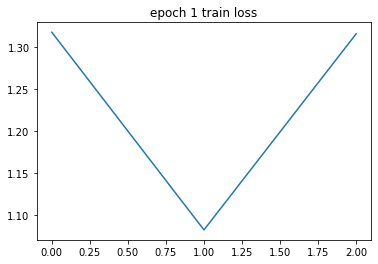

Valid Epoch 1: [3/3](100%)	 Loss: 1.276039
Valid Epoch 1: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 2: [2/6 (33%)]	Loss: 0.933610
Train Epoch 2: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 2: [4/6 (67%)]	Loss: 1.246231
Train Epoch 2: Acc: 75.00%	macro metrics: [p: 0.8333, r:0.8333, f1:0.7778]
Train Epoch 2: [6/6 (100%)]	Loss: 1.293653
Train Epoch 2: Acc: 66.67%	macro metrics: [p: 0.7222, r:0.6667, f1:0.6556]


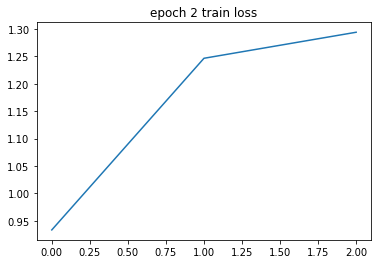

Valid Epoch 2: [3/3](100%)	 Loss: 1.328231
Valid Epoch 2: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 3: [2/6 (33%)]	Loss: 1.591215
Train Epoch 3: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 3: [4/6 (67%)]	Loss: 1.190114
Train Epoch 3: Acc: 50.00%	macro metrics: [p: 0.4444, r:0.6667, f1:0.5000]
Train Epoch 3: [6/6 (100%)]	Loss: 1.153569
Train Epoch 3: Acc: 66.67%	macro metrics: [p: 0.5000, r:0.6667, f1:0.5556]


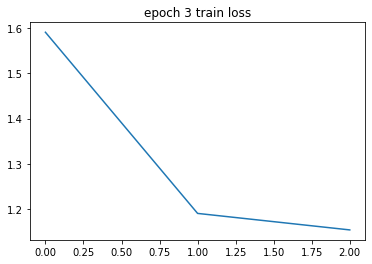

Valid Epoch 3: [3/3](100%)	 Loss: 1.326885
Valid Epoch 3: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 4: [2/6 (33%)]	Loss: 0.957594
Train Epoch 4: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 4: [4/6 (67%)]	Loss: 1.315579
Train Epoch 4: Acc: 50.00%	macro metrics: [p: 0.3333, r:0.3333, f1:0.3333]
Train Epoch 4: [6/6 (100%)]	Loss: 1.301384
Train Epoch 4: Acc: 33.33%	macro metrics: [p: 0.1667, r:0.3333, f1:0.2222]


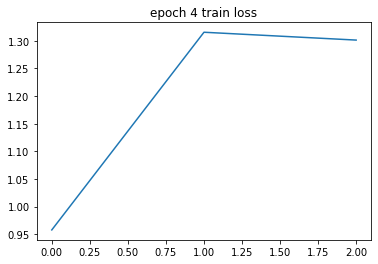

Valid Epoch 4: [3/3](100%)	 Loss: 1.243183
Valid Epoch 4: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 5: [2/6 (33%)]	Loss: 1.382488
Train Epoch 5: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 5: [4/6 (67%)]	Loss: 1.310380
Train Epoch 5: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 5: [6/6 (100%)]	Loss: 1.376408
Train Epoch 5: Acc: 16.67%	macro metrics: [p: 0.0833, r:0.1667, f1:0.1111]


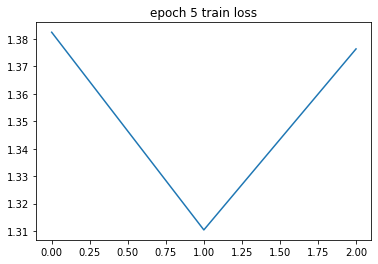

Valid Epoch 5: [3/3](100%)	 Loss: 1.319482
Valid Epoch 5: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 6: [2/6 (33%)]	Loss: 0.999986
Train Epoch 6: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 6: [4/6 (67%)]	Loss: 1.169596
Train Epoch 6: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 6: [6/6 (100%)]	Loss: 1.106702
Train Epoch 6: Acc: 83.33%	macro metrics: [p: 0.8889, r:0.8333, f1:0.8222]


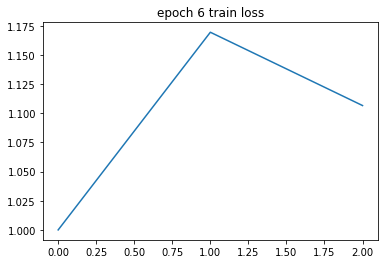

Valid Epoch 6: [3/3](100%)	 Loss: 1.284251
Valid Epoch 6: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 7: [2/6 (33%)]	Loss: 1.216668
Train Epoch 7: Acc: 50.00%	macro metrics: [p: 0.5000, r:0.2500, f1:0.3333]
Train Epoch 7: [4/6 (67%)]	Loss: 1.153207
Train Epoch 7: Acc: 50.00%	macro metrics: [p: 0.4444, r:0.5000, f1:0.3889]
Train Epoch 7: [6/6 (100%)]	Loss: 1.347343
Train Epoch 7: Acc: 33.33%	macro metrics: [p: 0.2778, r:0.3333, f1:0.3000]


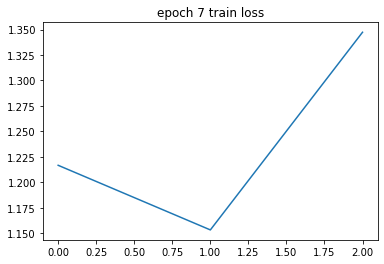

Valid Epoch 7: [3/3](100%)	 Loss: 1.276801
Valid Epoch 7: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 8: [2/6 (33%)]	Loss: 1.314362
Train Epoch 8: Acc: 0.00%	macro metrics: [p: 0.0000, r:0.0000, f1:0.0000]
Train Epoch 8: [4/6 (67%)]	Loss: 0.833267
Train Epoch 8: Acc: 50.00%	macro metrics: [p: 0.2222, r:0.3333, f1:0.2667]
Train Epoch 8: [6/6 (100%)]	Loss: 1.235231
Train Epoch 8: Acc: 33.33%	macro metrics: [p: 0.1667, r:0.3333, f1:0.2222]


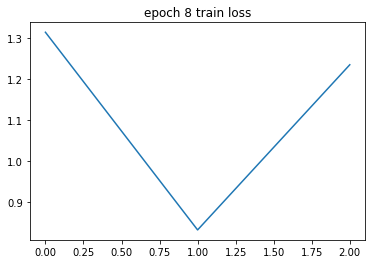

Valid Epoch 8: [3/3](100%)	 Loss: 1.212195
Valid Epoch 8: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 9: [2/6 (33%)]	Loss: 1.136352
Train Epoch 9: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 9: [4/6 (67%)]	Loss: 1.239584
Train Epoch 9: Acc: 75.00%	macro metrics: [p: 0.5556, r:0.6667, f1:0.6000]
Train Epoch 9: [6/6 (100%)]	Loss: 1.457271
Train Epoch 9: Acc: 50.00%	macro metrics: [p: 0.3889, r:0.5000, f1:0.4333]


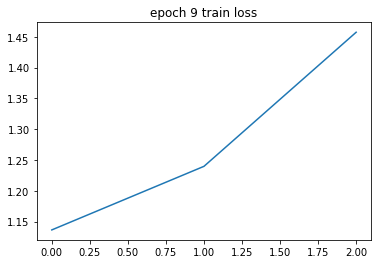

Valid Epoch 9: [3/3](100%)	 Loss: 1.302687
Valid Epoch 9: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]


Train Epoch 10: [2/6 (33%)]	Loss: 1.136390
Train Epoch 10: Acc: 100.00%	macro metrics: [p: 1.0000, r:1.0000, f1:1.0000]
Train Epoch 10: [4/6 (67%)]	Loss: 1.253726
Train Epoch 10: Acc: 50.00%	macro metrics: [p: 0.4444, r:0.5000, f1:0.3889]
Train Epoch 10: [6/6 (100%)]	Loss: 1.084615
Train Epoch 10: Acc: 50.00%	macro metrics: [p: 0.4667, r:0.5000, f1:0.4127]


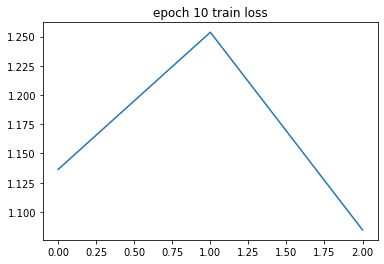

Valid Epoch 10: [3/3](100%)	 Loss: 1.250970
Valid Epoch 10: Acc: 33.33%	macro metrics: [p: 0.1111, r:0.3333, f1:0.1667]




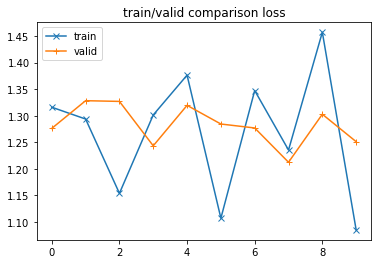

best(valid loss quota) early stopping epoch: 8, this epoch macro f1: 0.1667
total 10 epochs, best(valid macro f1) epoch: 1, this epoch macro f1: 0.1667
after 10 epochs, final test data macro f1: 0.2222


In [ ]:
# main entry, define optimization function, loss function and so on
# start epoch
# Use the loss of the valid dataset to make an early stop judgment. When it does not decline, this is the time when the model generalization is the best.
model = PCNN(cfg)
print(model)

optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=cfg.lr_factor, patience=cfg.lr_patience)
criterion = nn.CrossEntropyLoss()

best_f1, best_epoch = -1, 0
es_loss, es_f1, es_epoch, es_patience, best_es_epoch, best_es_f1, = 1000, -1, 0, 0, 0, -1
train_losses, valid_losses = [], []

logger.info('=' * 10 + ' Start training ' + '=' * 10)
for epoch in range(1, cfg.epoch + 1):
    train_loss = train(epoch, model, train_dataloader, optimizer, criterion, cfg)
    valid_f1, valid_loss = validate(epoch, model, valid_dataloader, criterion)
    scheduler.step(valid_loss)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if best_f1 < valid_f1:
        best_f1 = valid_f1
        best_epoch = epoch
    # 使用 valid loss 做 early stopping 的判断标准
    if es_loss > valid_loss:
        es_loss = valid_loss
        es_f1 = valid_f1
        best_es_f1 = valid_f1
        es_epoch = epoch
        best_es_epoch = epoch
        es_patience = 0
    else:
        es_patience += 1
        if es_patience >= cfg.early_stopping_patience:
            best_es_epoch = es_epoch
            best_es_f1 = es_f1

if cfg.show_plot:
    if cfg.plot_utils == 'matplot':
        plt.plot(train_losses, 'x-')
        plt.plot(valid_losses, '+-')
        plt.legend(['train', 'valid'])
        plt.title('train/valid comparison loss')
        plt.show()


print(f'best(valid loss quota) early stopping epoch: {best_es_epoch}, '
            f'this epoch macro f1: {best_es_f1:0.4f}')
print(f'total {cfg.epoch} epochs, best(valid macro f1) epoch: {best_epoch}, '
            f'this epoch macro f1: {best_f1:.4f}')

test_f1, _ = validate(0, model, test_dataloader, criterion,verbose=False)
print(f'after {cfg.epoch} epochs, final test data macro f1: {test_f1:.4f}')

This demo does not include parameter adjustment. Interested students can go to [deepke] by themselves（ http://openkg.cn/tool/deepke ）Warehouse, download and use more models:)